# Part 2: Exploratory Data Analysis (EDA)

In this notebook, I'll explore the cleaned datasets generated in Part 1 (`label_yield.parquet` and `nasa_df.parquet`). 

The main goal is to get a feel for the data distributions and trends before moving to modeling. I'll specifically focus on **Cereals (Barley, Wheat, Rice, and Maize/Corn)** to see how their yields have changed over time and how they correlate with the weather variables.

### 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Standard plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
yield_df = pd.read_parquet('Parquet/label_yield.parquet')
nasa_df = pd.read_parquet('Parquet/nasa_df.parquet')

# Quick sanity check on dimensions
print("Yield Data Shape:", yield_df.shape)
print("Weather Data Shape:", nasa_df.shape)

Yield Data Shape: (88465, 4)
Weather Data Shape: (107844, 5)


### 2. General Crop Yield Overview
Before filtering down to cereals, I want to look at the global landscape to see which crops have the highest yields on average.

C:\Users\PavinP\AppData\Local\Temp\ipykernel_15284\1309662339.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')


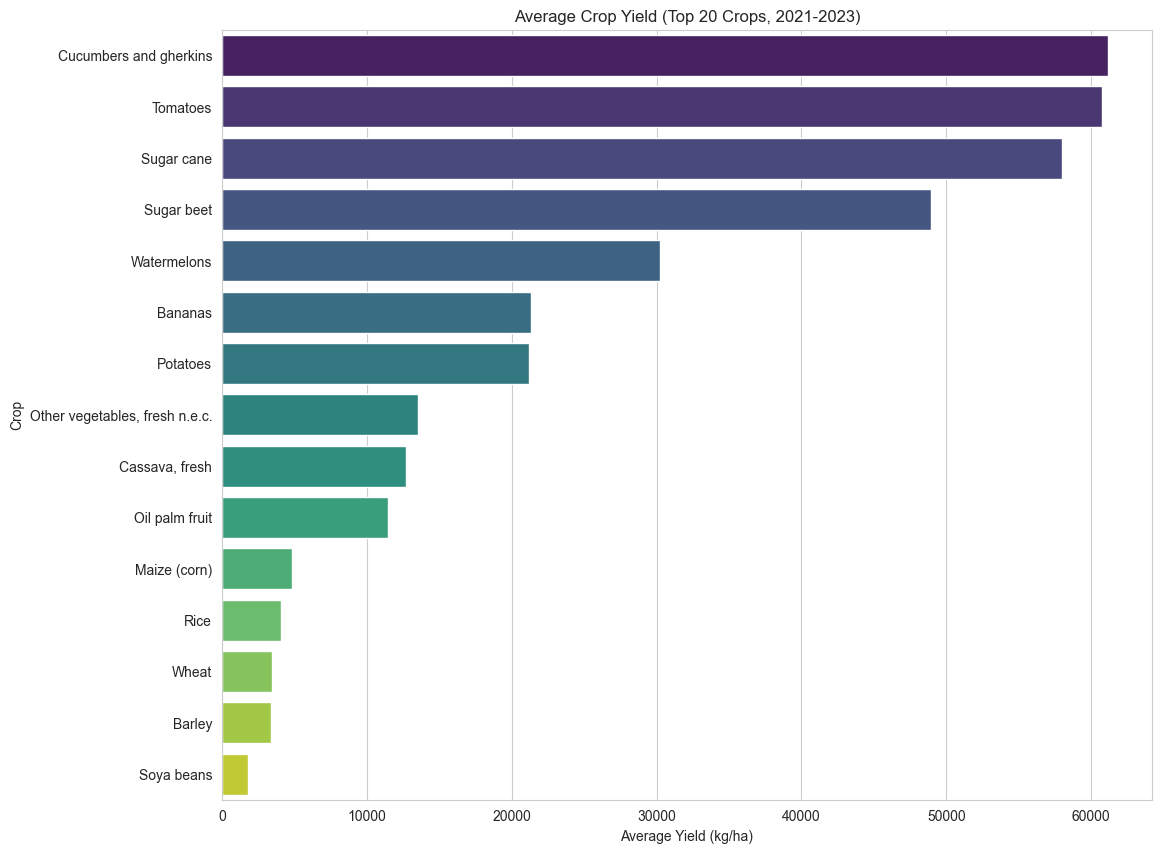

In [3]:
# Get the last 3 years of data for a recent snapshot
max_year = pd.to_datetime(yield_df['year']).dt.year.max()
recent_years = [max_year, max_year-1, max_year-2]

recent_df = yield_df[pd.to_datetime(yield_df['year']).dt.year.isin(recent_years)]

# Calculate average yield per crop and take the top 20
avg_yield_by_crop = recent_df.groupby('item')['label'].mean().reset_index()
avg_yield_by_crop = avg_yield_by_crop.sort_values(by='label', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='label', y='item', data=avg_yield_by_crop, palette='viridis')
plt.title(f'Average Crop Yield (Top 20 Crops, {min(recent_years)}-{max_year})')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop')
plt.show()

### 3. Filtering for Cereals
Now I'll narrow the dataset to the specific cereals relevant to the study: **Barley, Wheat, Rice, and Maize**.

In [4]:
# Using regex to catch variations like 'Rice, paddy' or 'Maize (corn)'
target_pattern = r"Barley|Wheat|Rice|Maize|Corn"

cereals_df = yield_df[yield_df['item'].str.contains(target_pattern, case=False)].copy()

print("Cereals Data Shape:", cereals_df.shape)
print("Unique Crops:", cereals_df['item'].unique())
print("Number of Areas:", cereals_df['area'].nunique())

cereals_df.head()

Cereals Data Shape: (25443, 4)
Unique Crops: ['Maize (corn)' 'Rice' 'Wheat' 'Barley']
Number of Areas: 192


,area,item,year,label
0,Afghanistan,Maize (corn),1970-12-31,1475.7
1,Afghanistan,Maize (corn),1971-12-31,1340.0
2,Afghanistan,Maize (corn),1972-12-31,1565.2
3,Afghanistan,Maize (corn),1973-12-31,1617.0
4,Afghanistan,Maize (corn),1974-12-31,1617.0


#### 3.1 Global Trends
Visualizing the average global yield for these cereals over the decades to check for long-term growth patterns.

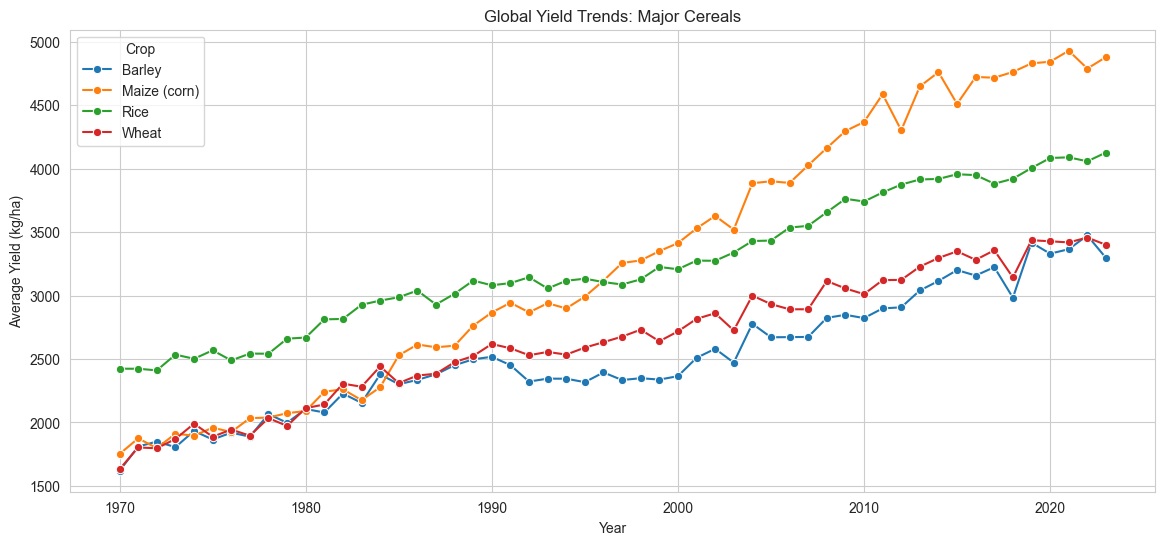

In [5]:
cereals_df['year_num'] = pd.to_datetime(cereals_df['year']).dt.year

# Aggregate global average yield per crop/year
global_trends = cereals_df.groupby(['item', 'year_num'])['label'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(x='year_num', y='label', hue='item', data=global_trends, marker='o')
plt.title('Global Yield Trends: Major Cereals')
plt.xlabel('Year')
plt.ylabel('Average Yield (kg/ha)')
plt.legend(title='Crop')
plt.show()

### 4. Weather Data Distributions
A quick inspection of the weather variables (Temperature, Rain, Solar Radiation) to spot any obvious outliers or skewness.

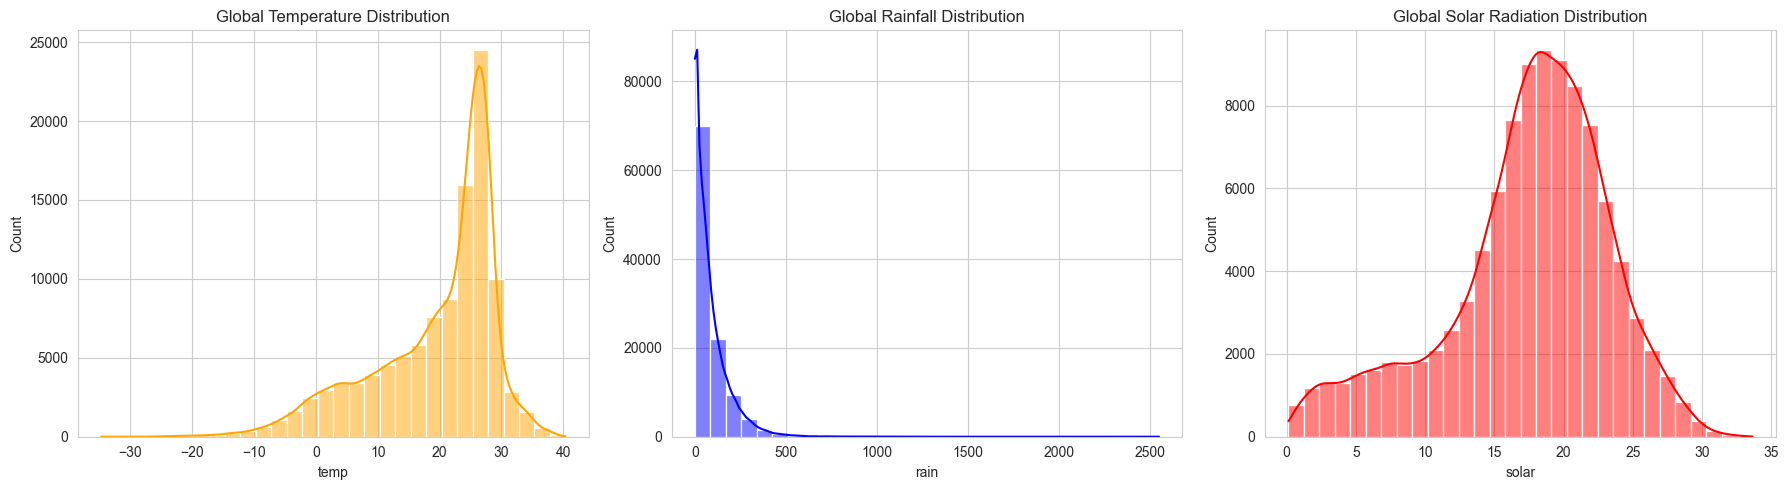

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(nasa_df['temp'].dropna(), bins=30, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Global Temperature Distribution')

sns.histplot(nasa_df['rain'].dropna(), bins=30, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Global Rainfall Distribution')

sns.histplot(nasa_df['solar'].dropna(), bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Global Solar Radiation Distribution')

plt.tight_layout()
plt.show()

### 5. Temporal Feature Analysis
I need to check if historical data (Lags and Moving Averages) are strong predictors. If $Yield_t$ is highly correlated with $Yield_{t-1}$, autoregressive features will be important for the model.

**Note:** I'm grouping by `['area', 'item']` to ensure I don't lag data across different countries or crops.

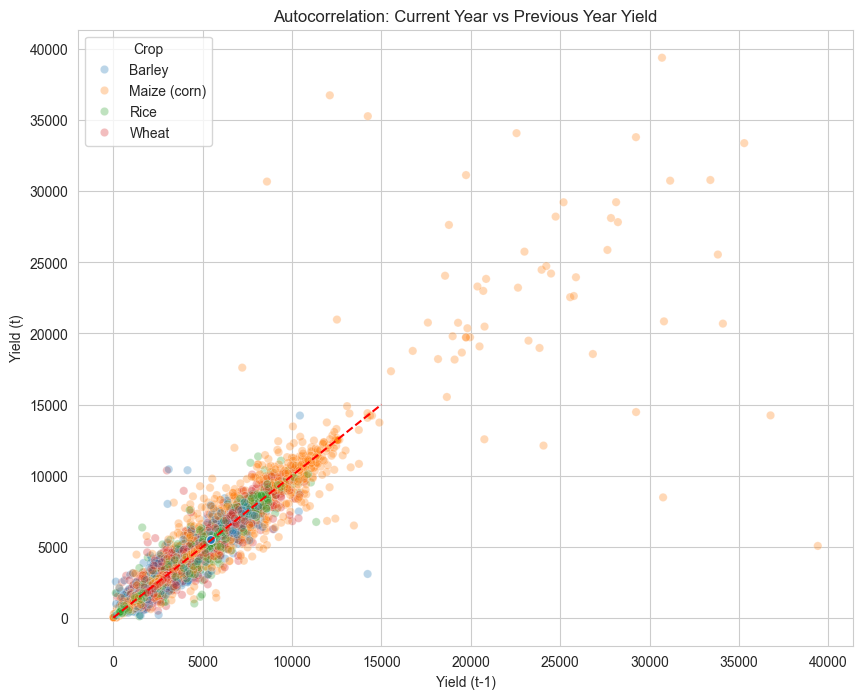

Overall Correlation between Year(t) and Year(t-1): 0.9540


In [7]:
lag_analysis = cereals_df.sort_values(['area', 'item', 'year_num']).copy()

# Calculate Lag 1 (Previous Year Yield)
lag_analysis['yield_lag_1'] = lag_analysis.groupby(['area', 'item'])['label'].shift(1)

# Filter for recent years (>= 2010) just for a cleaner plot
plot_data = lag_analysis[lag_analysis['year_num'] >= 2010]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='yield_lag_1', y='label', hue='item', data=plot_data, alpha=0.3)
plt.plot([0, 15000], [0, 15000], color='red', linestyle='--') # Identity line
plt.title('Autocorrelation: Current Year vs Previous Year Yield')
plt.xlabel('Yield (t-1)')
plt.ylabel('Yield (t)')
plt.legend(title='Crop')
plt.show()

# quantitative correlation score
corr_score = lag_analysis['label'].corr(lag_analysis['yield_lag_1'])
print(f"Overall Correlation between Year(t) and Year(t-1): {corr_score:.4f}")

#### 5.2 Moving Averages
Testing if a 3-year moving average (smoothing the last 3 years) provides a robust trend signal.

In [8]:
# 3-year rolling mean of the shifted values (using t-1, t-2, t-3)
lag_analysis['MA_3_lag'] = lag_analysis.groupby(['area', 'item'])['label'].shift(1).rolling(window=3).mean()

valid = lag_analysis.dropna(subset=['MA_3_lag'])

r2 = r2_score(valid['label'], valid['MA_3_lag'])
print(f"R² (Actual vs 3-Year Moving Avg): {r2:.4f}")

R² (Actual vs 3-Year Moving Avg): 0.9165


### 6. Correlation: Weather vs. Yield
Since crop yields are annual, I'll aggregate the monthly weather data into annual averages to check for correlations.

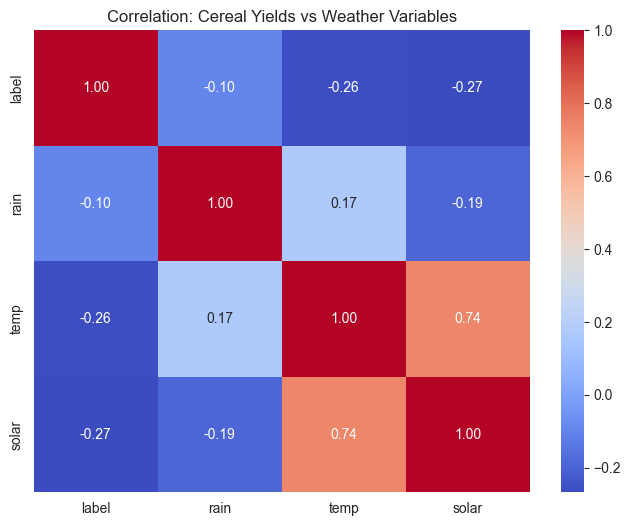

In [9]:
nasa_df['year'] = pd.to_datetime(nasa_df['date']).dt.year

# Aggregate weather by Year and Area
weather_annual = nasa_df.groupby(['area', 'year']).agg({
    'rain': 'sum',   # Total cumulative rain
    'temp': 'mean',  # Avg temp
    'solar': 'mean'  # Avg solar radiation
}).reset_index()

# Merge with Cereals Data
cereals_merge = cereals_df[['area', 'item', 'year_num', 'label']].rename(columns={'year_num': 'year'})
merged_df = pd.merge(cereals_merge, weather_annual, on=['area', 'year'], how='inner')

plt.figure(figsize=(8, 6))
corr_matrix = merged_df[['label', 'rain', 'temp', 'solar']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Cereal Yields vs Weather Variables')
plt.show()

### 7. Seasonality Check
Although the model uses annual data, I want to visualize the monthly weather averages to confirm the data follows logical seasonal patterns (e.g., higher temps in summer).

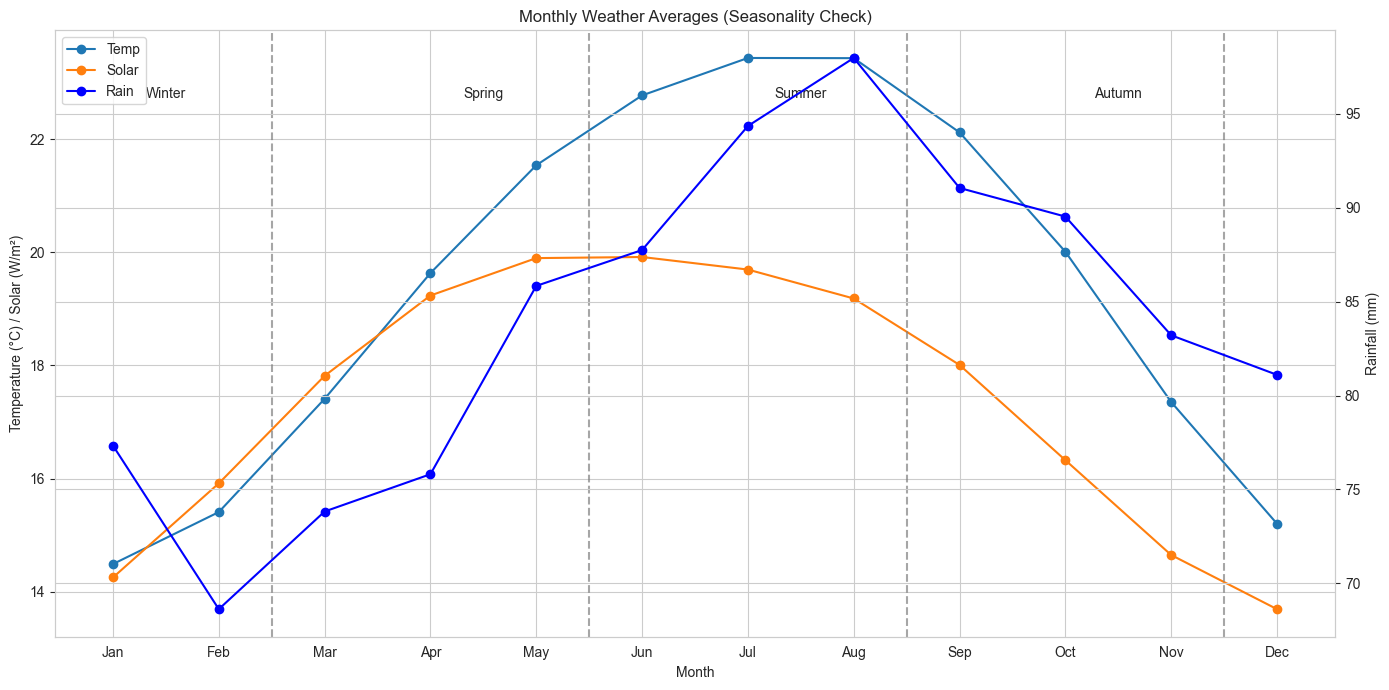

In [10]:
# Extract month
nasa_df['month'] = pd.to_datetime(nasa_df['date']).dt.month

seasonal_weather = nasa_df.groupby('month')[['rain', 'temp', 'solar']].mean()

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: Temp and Solar
ln1 = ax1.plot(seasonal_weather.index, seasonal_weather['temp'], marker='o', label='Temp')
ln2 = ax1.plot(seasonal_weather.index, seasonal_weather['solar'], marker='o', label='Solar')
ax1.set_ylabel("Temperature (°C) / Solar (W/m²)")

# Right axis: Rain
ax2 = ax1.twinx()
ln3 = ax2.plot(seasonal_weather.index, seasonal_weather['rain'], marker='o', label='Rain', color='blue')
ax2.set_ylabel("Rainfall (mm)")

# Formatting X-axis
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax1.set_xlabel("Month")

# Adding season separators for context
season_boundaries = [2.5, 5.5, 8.5, 11.5]
for x in season_boundaries:
    ax1.axvline(x=x, color='gray', linestyle='--', alpha=0.7)

ax1.text(1.5, ax1.get_ylim()[1]*0.95, 'Winter', ha='center')
ax1.text(4.5, ax1.get_ylim()[1]*0.95, 'Spring', ha='center')
ax1.text(7.5, ax1.get_ylim()[1]*0.95, 'Summer', ha='center')
ax1.text(10.5, ax1.get_ylim()[1]*0.95, 'Autumn', ha='center')

lns = ln1 + ln2 + ln3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc="upper left")

plt.title("Monthly Weather Averages (Seasonality Check)")
plt.tight_layout()
plt.show()

### 8. Geographic Analysis
Since yield varies drastically by location, I need to confirm the geographic spread. 

*Note: This section loads the raw `yield_final.csv` separately for the map visualization to ensure country names match the plotting library's expectations.*

In [11]:
import plotly.express as px

try:
    # Loading CSV specifically for the map viz
    yield_csv = pd.read_csv('Data/yield_final.csv')
    
    # Filter: Rice only, recent years
    rice_df = yield_csv[yield_csv['Item'].str.contains('Rice', case=False, na=False)].copy()
    max_year = rice_df['Year'].max()
    recent_rice_df = rice_df[rice_df['Year'] >= (max_year - 2)].copy()

    # Average Yield per Country
    country_stats = recent_rice_df.groupby('Area')['Yield (kg/ha)'].mean().reset_index()
    print(f"Prepared {len(country_stats)} countries for mapping.")
except FileNotFoundError:
    print("Warning: 'Data/yield_final.csv' not found. Skipping map.")
    country_stats = pd.DataFrame()


if not country_stats.empty:
    country_stats = country_stats.rename(columns={'Area': 'Country'})

    fig = px.choropleth(
        country_stats,
        locations='Country',
        color='Yield (kg/ha)',
        locationmode='country names',
        color_continuous_scale='YlGn',
        title=f'Global Rice Yield (Choropleth) - {max_year-2}-{max_year}',
        labels={'Yield (kg/ha)': 'Average Rice Yield (kg/ha)'},
        hover_name='Country',
        hover_data={'Yield (kg/ha)': True},
        projection='natural earth'
    )

    fig.update_layout(
        title_font_size=18,
        geo=dict(
            showframe=False,
            showcoastlines=True,
            landcolor='#f0f0f0',
            showland=True,
            showcountries=True,
            countrycolor='black'
        )
    )

    fig.show()
else:
    print("Skipping plot due to missing data.")

Prepared 117 countries for mapping.


C:\Users\PavinP\AppData\Local\Temp\ipykernel_15284\3260102320.py:23: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(
